## **The Goal: Predict how fast an AI model runs!**
We need to help Alice to find the best configuration for each AI model. 

#### **Hint:**
The AI models can be represented as graphs, where a node is a tensor operation and an edge
represents a tensor. A compilation (like c compiler) configuration controls how the compiler transforms the graph for a specific optimization pass. 

#### **Dataset:**
Participants are provided with a dataset, called TpuGraphs, which is a performance prediction dataset on XLA HLO graphs running on Tensor Processing Units (TPU) v3.

The dataset consists of two compilter optimization collections: layout and tile.

*******************
#### **Evaluation:**
The competition is evaluated based on two metrics:
1. For the tile:xla collection, it uses the (1-slowdown) incurred of the top-k predictions.
2. For the layout:* collections, the competition uses the kendal Tau Correlation (a ranking metric: how well does your model-predicted ranking, correspond to the real ranking of runtimes).

#### **Submission:**
Participants are required to submit a CSV file with headers ID,TopConfigs. Each npz/**/test/*.npz file must have one row in the CSV file.

> **The competition started on August 29, 2023, and the final submission deadline is November 17, 2023.
>You can find more details about the competition [here](https://www.kaggle.com/competitions/predict-ai-model-runtime/overview).**

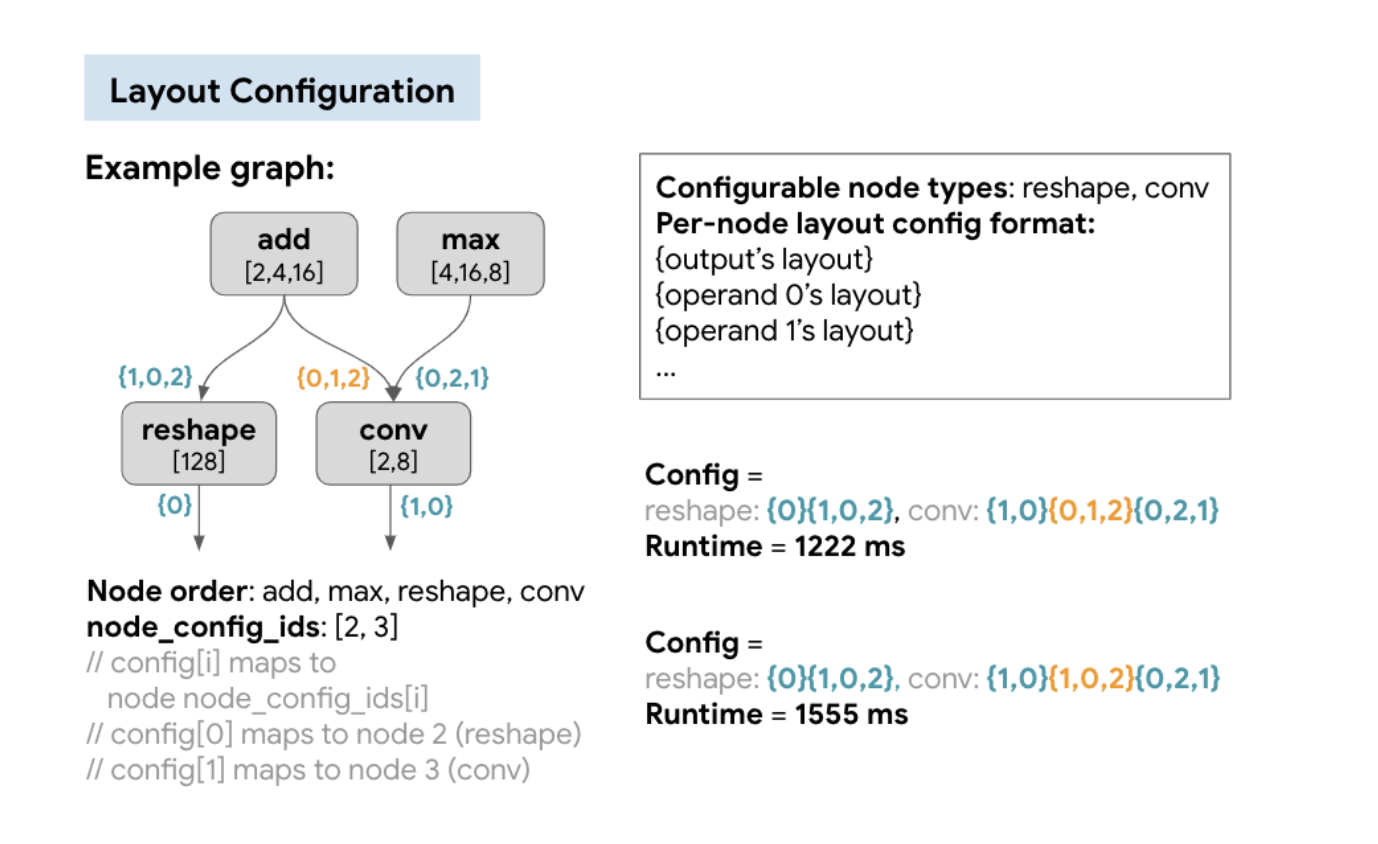

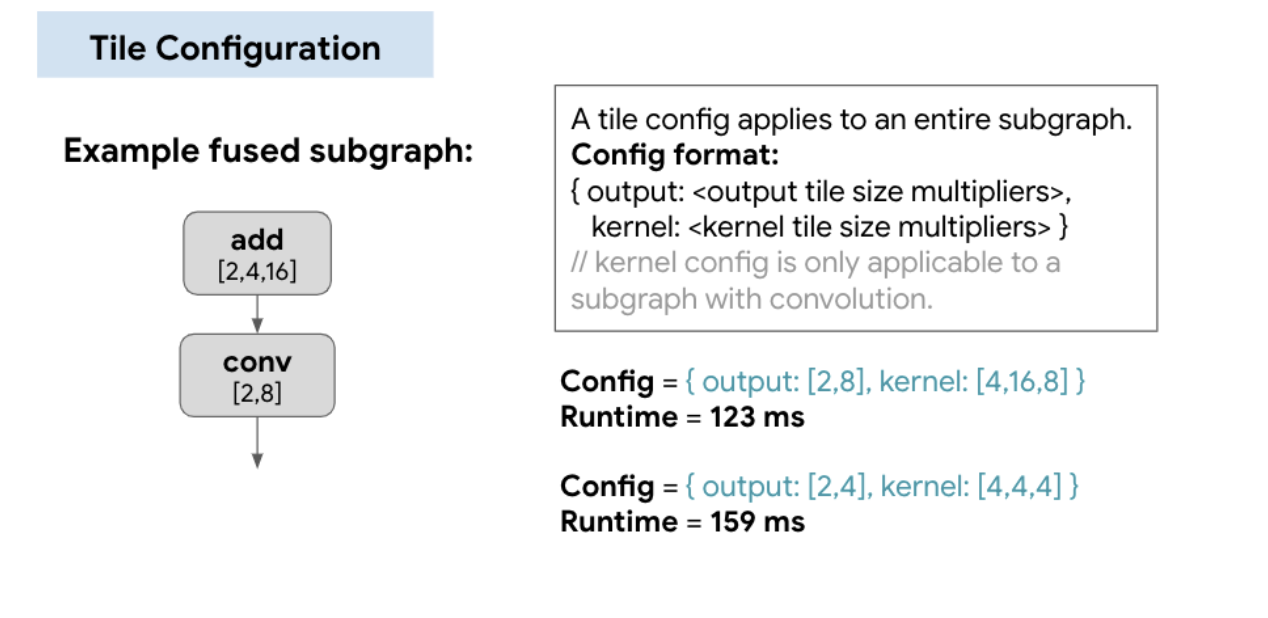

#### **1. Import Libraries**

In [168]:
# Import libraries
import numpy as np
import pandas as pd 
import math
import os 

# Pytorch family
import torch
from torch.nn import functional as F
# Padding sequence
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
# Pytorch lightning for training
import pytorch_lightning as pl

# Progress tracking 
from tqdm import tqdm
# Hugging face datasets library for processing data
from datasets import Dataset
# Python std library provides a decorator for making classes
from dataclasses import dataclass
# Pathlib deals with file path
from pathlib import Path
# Typing defines data path
from typing import Dict, Optional, List, Union, Tuple

# Encapsulate the outputs of the model
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
# Handling chunking during the forward pass of a model
from transformers.pytorch_utils import apply_chunking_to_forward
# Transformer activations
from transformers.activations import ACT2FN
# Metrics
import torchmetrics as tm

In [169]:
# Define constants for the project
# Number of node operations
NODE_OP_CODES  = 120
# Number of node features
NODE_FEATS = 140
# Number of config features
CONFIG_FEATS = 24
# Number of combined node and configuration features
NODE_CONFIG_FEATS = 18

#### **2. Generating Tile DataFrame**

In [170]:
# Data path
DATA_DIR = '/kaggle/input/tpugraphs/npz'

In [171]:
def generate_tile_df() -> pd.DataFrame:
    '''Generate wanted dataframe'''
    
    # Create a list of file paths
    file_paths = []
    for elem in (Path(DATA_DIR) / 'tile').rglob("*"):
        if elem.is_file():
            file_paths.append(str(elem))

    # Create a DataFrame with a single column "paths" containing the file paths
    df = pd.DataFrame({'paths': file_paths})

    # Add new columns to the DataFrame
    # Using apply() to apply a function for each element in this column
    df['split'] = df['paths'].apply(lambda x: Path(x).parent.name)
    df['configuration'] = df['paths'].apply(lambda x: Path(x).parent.parent.name).astype(str)
    df['extra'] = df['paths'].apply(lambda x: Path(x).parent.parent.parent.name).astype(str)
    df['model_name'] = df['paths'].apply(lambda x: Path(x).stem)
    df['collection'] = df['extra'] + ':' + df['configuration']
    df['ID'] = df['collection'] + ':' + df['model_name']

    return df

In [172]:
# Generate the tile DataFrame
tile_df = generate_tile_df()

# Display 
tile_df.head()

,paths,split,configuration,extra,model_name,collection,ID
0,/kaggle/input/tpugraphs/npz/tile/xla/valid/res...,valid,xla,tile,resnet_v1_50_official_batch_128_bf16_2bea628b7...,tile:xla,tile:xla:resnet_v1_50_official_batch_128_bf16_...
1,/kaggle/input/tpugraphs/npz/tile/xla/valid/inc...,valid,xla,tile,inception_v3_batch_128_train_40fa8f86f121f00a,tile:xla,tile:xla:inception_v3_batch_128_train_40fa8f86...
2,/kaggle/input/tpugraphs/npz/tile/xla/valid/inc...,valid,xla,tile,inception_v3_batch_128_train_-23e94c034a65a177,tile:xla,tile:xla:inception_v3_batch_128_train_-23e94c0...
3,/kaggle/input/tpugraphs/npz/tile/xla/valid/inc...,valid,xla,tile,inception_v3_batch_128_train_171f4371caf28639,tile:xla,tile:xla:inception_v3_batch_128_train_171f4371...
4,/kaggle/input/tpugraphs/npz/tile/xla/valid/mlp...,valid,xla,tile,mlperf_bert_batch_24_2x2_-25e30862c042a2b8,tile:xla,tile:xla:mlperf_bert_batch_24_2x2_-25e30862c04...


#### **3. Define functions**

In [173]:
def edges_adjacency(edges: torch.Tensor, add_diagonal = True) -> torch.tensor:
    '''Create the adjacency matrix of edges'''
    
    # Identify the number of nodes
    num_nodes = edges.max().item() + 1
    
    # Initialize an adjacency matrix
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    
    # edges object contains the index of the Edges
    adj_matrix[edges[:, 0], edges[:, 1]] = 1
    
    # If add_self_edges is True, set the diagonal to 1
    if add_diagonal:
        adj_matrix.fill_diagonal_(1)
        
    return adj_matrix

def tile_loader(path: str) -> dict:
    '''Load data from a numpy file, convert to PyTorch tensors, and create an adjacency matrix.'''
    
    # Load numpy data and convert to PyTorch tensors
    tile_dict =  dict(np.load(path))
    # convert numpy to pytorch
    for key in tile_dict:
        tile_dict[key] = torch.from_numpy(tile_dict[key])
    
    # add adjacency matrix to dictionary
    tile_dict['edges_adjacency'] = edges_adjacency(tile_dict['edge_index'])
    
    return tile_dict

def node_cls_token(elem_dict, shift_node_config_ids:bool=True):
    '''Add a 'cls' token to node data and shift node_config_ids if needed.'''
    elem_dict['node_opcode'] = torch.cat([torch.tensor([0]), elem_dict['node_opcode']])
    elem_dict['node_feat'] = torch.cat([torch.zeros((1, elem_dict['node_feat'].shape[1])), elem_dict['node_feat']])
    elem_dict['edges_adjacency'] = F.pad(elem_dict['edges_adjacency'], (1,0,1,0), value = 1)   
    if 'node_config_ids' in elem_dict and shift_node_config_ids:
        elem_dict['node_config_ids'] = elem_dict['node_config_ids'] + 1
        
    return elem_dict


In [174]:
class TileDataset(torch.utils.data.Dataset):
    
    def __init__(self, df:pd.DataFrame, add_cls_token = True, num_configs = 10, max_configs = None):
        self.df = df
        self.add_cls_token = add_cls_token
        self.num_configs = num_configs
        self.max_configs = max_configs
    
    # returns the number the data samples (the number of rows in DataFrame)
    def __len__(self) -> int:
        return len(self.df)
    
    # select a subset(index) of configurations
    def select_configs(self, total_configs: int) -> np.ndarray:
        if self.max_configs is not None:
            total_configs = min(total_configs, self.max_configs)
        if self.num_configs == -1:
            return np.arange(total_configs)
        if total_configs < self.num_configs:
            # allow the same configuration to be selected more than once!
            return np.random.choice(total_configs, self.num_configs, replace = True)
        
        return np.random.choice(total_configs, self.num_configs, replace=False)
    
    # configure index function of the class
    def __getitem__(self, idx:int, selected_configs: List[int] = None):
        # load the data sample at index idx, each data sample is a model
        tile_dict = tile_loader(self.df.paths[idx])
        # form a random configuration index array
        if selected_configs is None:
            selected_configs = self.select_configs(tile_dict['config_feat'].shape[0])
        
        # pop() remove the key and return the value
        tile_dict['node_config_feat'] = tile_dict.pop('config_feat')[selected_configs]
        tile_dict['node_config_feat'] = F.pad(tile_dict['node_config_feat'].unsqueeze(1), (0, NODE_CONFIG_FEATS))
        tile_dict['config_runtime'] = tile_dict['config_runtime'][selected_configs].float()
        tile_dict['config_runtime'] /= tile_dict['config_runtime_normalizers'][selected_configs].float()
        tile_dict['node_config_ids'] = torch.zeros((1, ))
        tile_dict['selected_idxs'] = selected_configs
        
        if self.add_cls_token:
            tile_dict = node_cls_token(tile_dict, False)
            
        return tile_dict

In [175]:
tile_dataset = TileDataset(tile_df)

In [178]:
elem = tile_dataset[0]
for k,v in elem.items():
    print('Item:', k, '\nShape:', v.shape)

Item: node_feat 
Shape: torch.Size([81, 140])
Item: node_opcode 
Shape: torch.Size([81])
Item: edge_index 
Shape: torch.Size([86, 2])
Item: config_runtime 
Shape: torch.Size([10])
Item: config_runtime_normalizers 
Shape: torch.Size([3246])
Item: edges_adjacency 
Shape: torch.Size([81, 81])
Item: node_config_feat 
Shape: torch.Size([10, 1, 42])
Item: node_config_ids 
Shape: torch.Size([1])
Item: selected_idxs 
Shape: (10,)


- **`node_feat`**: Represents **node features** in a graph. The tensor shape indicates there are 81 nodes, each having 140 features.
- **`node_opcode`**: Likely signifies **operation codes** associated with each node. The tensor shape suggests there are 81 nodes, each having an operation code.
- **`edge_index`**: Represents the **indices of edges** in the graph. The tensor shape indicates there are 86 edges, each defined by a pair of nodes (source and target).
- **`config_runtime`**: Likely represents **runtimes** or other measurements tied to different configurations. The tensor shape suggests there are measurements for 10 configurations.
- **`config_runtime_normalizers`**: Likely signifies **normalizing values** for the runtimes of configurations. It's unclear why there are 3246 of these for 10 configurations.
- **`edges_adjacency`**: Represents the **adjacency matrix** of the graph, illustrating the connections between the 81 nodes.
- **`node_config_feat`**: Likely represents **configuration features** associated with each node. The 3D tensor (10x1x42) is somewhat unusual; a 2D tensor (10x42) might be more common.
- **`node_config_ids`**: Likely represents some sort of **identifier** for each configuration. It's unclear why there is only one of these for 10 configurations.
- **`selected_idxs`**: Represents **indices of selected configurations or nodes**. There are 10 of these, but it's not clear what they are selecting.

## Custom Functions for Data Preparation and Collation

In [ ]:
def pad_edge_adjacency(edges_adjacency_list):
    max_len = max([elem.shape[0] for elem in edges_adjacency_list])
    padding = lambda elem: F.pad(elem, (0, max_len - elem.shape[0], max_len - elem.shape[0]))
    
    return torch.stack([padding(elem) for elem in edges_adjacency_list])